In this notebook, I will be playing around with clustering molecules from different patents and how different the clustering looks like depending on the type of algorithm I use. I will be using Agglomerative hierarchical clustering, K Means Clustering, and DBSCAN clustering.

This was inspired by the work done by Greg Landrum in KNIME. I thought to replicate his work by using code as a good practice in coding!!!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors, AllChem
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.Chem import DataStructs
from sklearn import manifold
import seaborn as sns

First I will import the txt file available from KNIME.

In [2]:
df = pd.read_csv('CHEMBL3833.txt', sep = '\t')

In [3]:
df.head() #have a quick look at the data set.

,canonical_smiles,compound_chembl_id,standard_relation,standard_value,publication_year,document_chembl_id
0,O=C(Nc1ccc([C@H]2CNCCO2)cc1)c1cc(-c2ccccc2)[nH]n1,CHEMBL3663679,=,4.3,2015,CHEMBL3638918
1,O=C(Nc1ccc([C@@H]2CNCCO2)cc1F)c1n[nH]c2cc(F)ccc12,CHEMBL3672946,=,5.1,2015,CHEMBL3638970
2,O=C(Nc1ccc([C@H]2CNCCO2)cc1F)c1n[nH]c2cc(F)ccc12,CHEMBL3672947,=,0.9,2015,CHEMBL3638970
3,N#Cc1cccc(NC(=O)Nc2ccc([C@@H]3CNCCO3)cc2F)c1,CHEMBL3672948,=,1.5,2015,CHEMBL3638970
4,N#Cc1cccc(NC(=O)Nc2ccc([C@H]3CNCCO3)cc2F)c1,CHEMBL3672949,=,2.8,2015,CHEMBL3638970


The data set contains a list of molecules with their chembl ids, and the patents (with year) where they came from. 

In [4]:
df.shape #We have 690 rows and 6 columns

(690, 6)

Grouping by Document_chembl_id, then counting the number of times this patent appears in the data set and then sorting it in descending order, I could easily see how many compounds fall under each patent. 

In [5]:
df.groupby(['document_chembl_id'])['document_chembl_id'].count().sort_values(ascending = False)

document_chembl_id
CHEMBL3886960    320
CHEMBL3638970    138
CHEMBL3638821     74
CHEMBL3886345     55
CHEMBL3638918     54
CHEMBL3886861     36
CHEMBL3638700     13
Name: document_chembl_id, dtype: int64

Based on this, I will exclude the patents with less than 20 compounds. I will consider only ones which have 20 compounds and above.

In [6]:
df1 = df.groupby('document_chembl_id').filter(lambda x : len(x)>20) #drop all rows whose count is less than 20

In [7]:
df1.shape #dropping 13 rows from CHEMBL3638700, I am left with 677 rows.

(677, 6)

Now, I will randomly pick 15 compounds from each patent. I do this by using the .sample() function. I will then assign this to a new dataframe called df2.

In [8]:
df2 = df1.groupby("document_chembl_id").sample(n=15, random_state =42)

In [9]:
df2.shape #confirming the number of rows is correct 15*6 = 90.

(90, 6)

In [10]:
df2.head()

,canonical_smiles,compound_chembl_id,standard_relation,standard_value,publication_year,document_chembl_id
143,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccc(Cl)c34)cc2)CO1,CHEMBL3656478,=,3.3,2014,CHEMBL3638821
202,NC1=N[C@@H](CCc2ccc(NC(c3cccc(F)c3)C(F)(F)F)cc...,CHEMBL3660701,=,6.4,2014,CHEMBL3638821
157,NC1=N[C@@H](CCc2ccc(Nc3ncc(F)cn3)cc2)CO1,CHEMBL3656493,=,4.0,2014,CHEMBL3638821
139,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccnc34)cc2)CO1,CHEMBL3656474,=,0.6,2014,CHEMBL3638821
167,COc1ccc(Nc2ccc(CC[C@H]3COC(N)=N3)cc2)nc1,CHEMBL3656503,=,8.3,2014,CHEMBL3638821


So now I will draw the molecule for each canonical smile in the dataframe. I will put this in a new column. I am using the function AddMoleculeColumnToFrame from PandasTools. I found that this is the same as using Chem.MolFromSmiles() function from RDKit. 

In [11]:
PandasTools.AddMoleculeColumnToFrame(df2, smilesCol='canonical_smiles')

In [12]:
df2.head(1)

,canonical_smiles,compound_chembl_id,standard_relation,standard_value,publication_year,document_chembl_id,ROMol
143,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccc(Cl)c34)cc2)CO1,CHEMBL3656478,=,3.3,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4e40>


## Morgan Fingerprint

I will now obtain the Morgan Fingerprints for each molecule in the ROMol column. I do this by using the GetMorganFingerprintAsBitVect from RDKit. I also use nBits = 2048. I got this code from https://www.youtube.com/watch?v=-oHqQBUyrQ0&t=1254s

In [13]:
mfp = [AllChem.GetMorganFingerprintAsBitVect(i, 2, nBits = 2048) for i in df2['ROMol']]

In [14]:
df2.head(1)

,canonical_smiles,compound_chembl_id,standard_relation,standard_value,publication_year,document_chembl_id,ROMol
143,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccc(Cl)c34)cc2)CO1,CHEMBL3656478,=,3.3,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4e40>


Using the MorganFingerprint, I will now obtain the Tanimoto Similarity Distances. I do this by using the BulkTanimotoSimilarity from DataStructs. I got this code from http://rdkit.blogspot.com/2014/01/mds-i-fingerprints-2d.html

In [15]:
dist_mat = []
for i,fp in enumerate(mfp):
    dist_mat.append(DataStructs.BulkTanimotoSimilarity(mfp[i],mfp, returnDistance =1))
print(len(dist_mat))

90


In [16]:
#Would this code work as well? I tried this method but it gives 4005 rows instead of 90.
#from rdkit.ML.Cluster import Butina
#dists = []
#nfps = len(mfp)
#for i in range(1, nfps):
#    sims = DataStructs.BulkTanimotoSimilarity(mfp[i], mfp[:i])
#    dists.extend([1 - x for x in sims])


In [17]:
df2['distance'] = dist_mat #I will now add the results as a column in my dataframe.

In [18]:
df2.head(5)

,canonical_smiles,compound_chembl_id,standard_relation,standard_value,publication_year,document_chembl_id,ROMol,distance
143,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccc(Cl)c34)cc2)CO1,CHEMBL3656478,=,3.3,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4e40>,"[0.0, 0.5303030303030303, 0.45614035087719296,..."
202,NC1=N[C@@H](CCc2ccc(NC(c3cccc(F)c3)C(F)(F)F)cc...,CHEMBL3660701,=,6.4,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4820>,"[0.5303030303030303, 0.0, 0.44999999999999996,..."
157,NC1=N[C@@H](CCc2ccc(Nc3ncc(F)cn3)cc2)CO1,CHEMBL3656493,=,4.0,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4eb0>,"[0.45614035087719296, 0.44999999999999996, 0.0..."
139,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccnc34)cc2)CO1,CHEMBL3656474,=,0.6,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4cf0>,"[0.32727272727272727, 0.5303030303030303, 0.42..."
167,COc1ccc(Nc2ccc(CC[C@H]3COC(N)=N3)cc2)nc1,CHEMBL3656503,=,8.3,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4c80>,"[0.5, 0.5588235294117647, 0.4107142857142857, ..."


Next, I based on the obtained tanimoto distances, I will perform multidimensional scaling to output two dimensions, and use these as the coordinates of each of the compounds. I am using manifold.MDS function for this. The result is an array with two columns.

In [19]:
mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=1_000_000, n_jobs = 4, verbose=1,max_iter=1000)
results = mds.fit(dist_mat)
coords = results.embedding_
coords

/Users/elisha-fred/miniforge3/envs/base_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:512: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


array([[-0.69759977, -2.32447546],
       [ 0.24449345, -2.34656013],
       [-0.31554779, -2.50620882],
       [-0.69610406, -2.41443818],
       [-0.47135255, -2.46261367],
       [ 0.30937366, -2.43531771],
       [-0.37492566, -2.41174174],
       [-0.2491598 , -2.51203086],
       [-0.19714472, -2.6244971 ],
       [-0.10789829, -2.56469815],
       [-0.80002087, -2.23240698],
       [-0.53417851, -2.41401933],
       [ 0.02720271, -2.40227274],
       [-0.17023118, -2.2428115 ],
       [ 0.05659716, -2.57968311],
       [ 0.15542176,  1.03073853],
       [ 0.23129329,  1.20407443],
       [ 0.12037625,  0.81445442],
       [-0.10065277,  1.29620318],
       [-0.07173039,  0.75397535],
       [ 0.60408795,  0.67392584],
       [ 0.56805096,  0.8218868 ],
       [ 0.43336569,  1.16738624],
       [ 0.27385636,  0.808088  ],
       [ 0.058332  ,  1.16857818],
       [ 0.49191604,  1.00485145],
       [-0.10039255,  1.0182799 ],
       [ 0.6452757 ,  0.57328814],
       [-0.01889185,

In [20]:
df3 = pd.DataFrame(coords) #put the array into a dataframe and then adding this onto df2

In [21]:
df3.head()

,0,1
0,-0.697600,-2.324475
1,0.244493,-2.346560
2,-0.315548,-2.506209
3,-0.696104,-2.414438
4,-0.471353,-2.462614


In [22]:
df3 = df3.rename({0: 'col1', 1: 'col2'}, axis=1)

In [23]:
df3.dtypes

col1    float64
col2    float64
dtype: object

In [24]:
df3

,col1,col2
0,-0.697600,-2.324475
1,0.244493,-2.346560
2,-0.315548,-2.506209
3,-0.696104,-2.414438
4,-0.471353,-2.462614
...,...,...
85,-0.147268,0.189004
86,0.326702,0.550673
87,0.339676,0.292628
88,0.830641,-0.588905


In [25]:
df2 = pd.concat([df2.reset_index(drop=True), df3.reset_index(drop = True)], axis=1) #reset index was done to not get a NaN value after concatenation of two dataframes

In [26]:
df2

,canonical_smiles,compound_chembl_id,standard_relation,standard_value,publication_year,document_chembl_id,ROMol,distance,col1,col2
0,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccc(Cl)c34)cc2)CO1,CHEMBL3656478,=,3.3,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4e40>,"[0.0, 0.5303030303030303, 0.45614035087719296,...",-0.697600,-2.324475
1,NC1=N[C@@H](CCc2ccc(NC(c3cccc(F)c3)C(F)(F)F)cc...,CHEMBL3660701,=,6.4,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4820>,"[0.5303030303030303, 0.0, 0.44999999999999996,...",0.244493,-2.346560
2,NC1=N[C@@H](CCc2ccc(Nc3ncc(F)cn3)cc2)CO1,CHEMBL3656493,=,4.0,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4eb0>,"[0.45614035087719296, 0.44999999999999996, 0.0...",-0.315548,-2.506209
3,NC1=N[C@@H](CCc2ccc(Nc3cccc4cccnc34)cc2)CO1,CHEMBL3656474,=,0.6,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4cf0>,"[0.32727272727272727, 0.5303030303030303, 0.42...",-0.696104,-2.414438
4,COc1ccc(Nc2ccc(CC[C@H]3COC(N)=N3)cc2)nc1,CHEMBL3656503,=,8.3,2014,CHEMBL3638821,<rdkit.Chem.rdchem.Mol object at 0x15b3b4c80>,"[0.5, 0.5588235294117647, 0.4107142857142857, ...",-0.471353,-2.462614
...,...,...,...,...,...,...,...,...,...,...
85,O=C(NCc1ccc([C@@H]2CNCCO2)cc1)c1ccc(Cl)nc1,CHEMBL3903186,=,9.0,2016,CHEMBL3886960,<rdkit.Chem.rdchem.Mol object at 0x15b40c190>,"[0.8414634146341463, 0.8764044943820225, 0.833...",-0.147268,0.189004
86,O=C(Nc1ccc(C2CNCCO2)cc1)c1csc(-c2cnccn2)n1,CHEMBL3909321,=,7.5,2016,CHEMBL3886960,<rdkit.Chem.rdchem.Mol object at 0x15b40c200>,"[0.8666666666666667, 0.8969072164948454, 0.847...",0.326702,0.550673
87,CC(CO)(CCl)COc1ccc(C(=O)Nc2ccc(C3CNCCO3)cc2)cc1,CHEMBL3986472,=,2.4,2016,CHEMBL3886960,<rdkit.Chem.rdchem.Mol object at 0x15b40c270>,"[0.8804347826086957, 0.8865979381443299, 0.875...",0.339676,0.292628
88,O=C(Nc1ccc(C2CCNC2)cc1)c1ncccc1F,CHEMBL3889958,=,1768.8,2016,CHEMBL3886960,<rdkit.Chem.rdchem.Mol object at 0x15b40c2e0>,"[0.8607594936708861, 0.8554216867469879, 0.821...",0.830641,-0.588905


I will now plot these 2D coordinates in a scatterplot, colouring each data point based on the patent it came from.

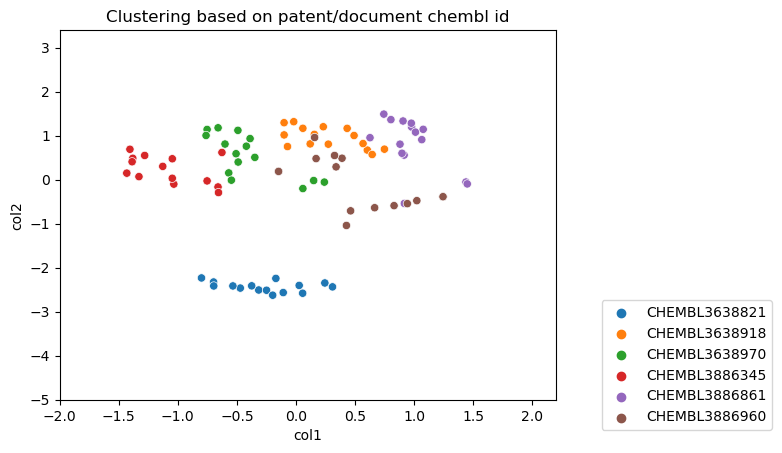

In [27]:
sns.scatterplot(x = 'col1', y = 'col2', hue = 'document_chembl_id', palette = 'tab10', data = df2)
plt.legend(bbox_to_anchor = (1.45, -0.10), loc='lower right')
plt.title("Clustering based on patent/document chembl id")
plt.xlim(-2.0, 2.2)
plt.ylim(-5.0, 3.4);

From this point on, I will now start to cluster these data points using three different types of clustering algorithms. Hierarchical Agglomerative Clustering, K Means Clustering, and DBSCAN.

## Hierarchical Clustering

In [28]:
import scipy

In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

First I am plotting the dendrogram to visualise how many clusters is best. I will be using "Average" as the method, in contrast to "Complete" and "Single". I will also be using Euclidean distance as the metric.

In [30]:
X = df2[['col1','col2']].values

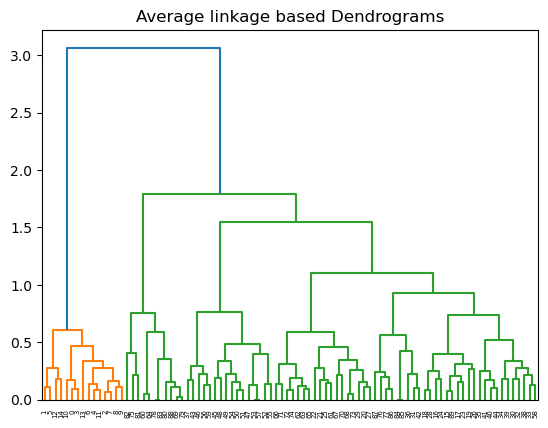

In [31]:
scipy.spatial.distance.pdist(X, metric='euclidean')
plt.title("Average linkage based Dendrograms")  
dend = dendrogram(linkage(X, method='average'))

It seems that the best number of clusters is 6, based on this dendrogram. I will therefore be using n_clusters = 6. After constructing the model, I will plot the clusters on a scatterplot, with hues based on the results of the Agglomerative clustering.

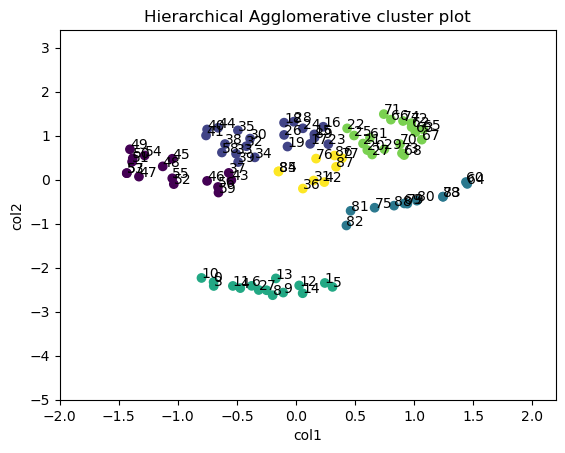

In [34]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')
pred = cluster.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=pred)

for i in range(0,len(df2.col1)):
    txt = df2.index[i]
    plt.annotate(txt, (df2.col1[i], df2.col2[i]))

plt.title("Hierarchical Agglomerative cluster plot")
plt.xlabel("col1")
plt.ylabel("col2")
plt.xlim(-2.0, 2.2)
plt.ylim(-5.0, 3.4);

In [35]:
pred

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 4, 4,
       4, 1, 1, 4, 1, 4, 1, 4, 1, 5, 1, 1, 1, 1, 5, 0, 1, 1, 1, 1, 5, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 4, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 5, 5, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5,
       2, 1])

In [36]:
from sklearn.metrics import silhouette_score
score1 = round(silhouette_score(X, pred, metric='euclidean'),2)

In [37]:
score1

0.51

## K Means

Next I will do K Means Clustering and compare this with Agglomerative Clustering.

In [38]:
from sklearn.cluster import KMeans

I will first plot use the elbow method to identify the best n_clusters to use for K Means clustering.

In [39]:
inertia = []

for k in range(1, 11): #maximum K value is 10
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)  
    x = kmeans.inertia_
    inertia.append(x)

print(inertia)

[183.796315673897, 75.86778341435755, 40.60530844243456, 22.555997188182868, 17.046221680790424, 13.445844497550189, 11.098236182160647, 9.34320276440251, 7.899440342822036, 6.607793459017783]


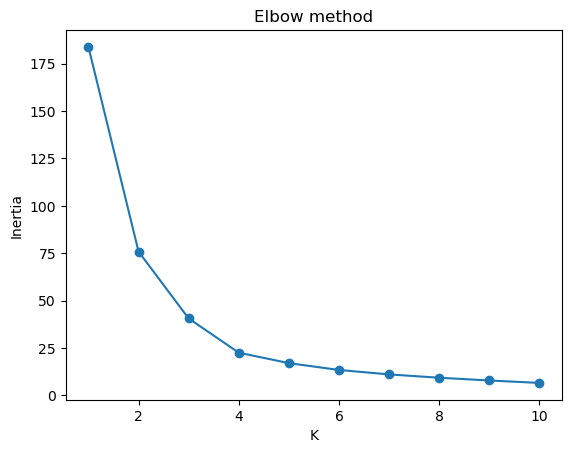

In [40]:
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

Based on the elbow method, it seems K = 3 is the best. I will also plot a scatter plot to visualise how the algorithm has clustered the data points.

In [41]:
x = X[:,0]
y = X[:,1]

In [42]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X)
cent = kmeans.cluster_centers_ #to get the centroids

In [43]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1,
       1, 1], dtype=int32)

In [44]:
from sklearn.metrics import silhouette_score
score2 = round(silhouette_score(X, cluster_labels, metric='euclidean'),2)

In [45]:
score2

0.49

The silhouette score of K Means is 0.49, slightly lower than the silhouette score of Agglomerative clustering at 0.51.

In [46]:
k =3
compound = df2.index

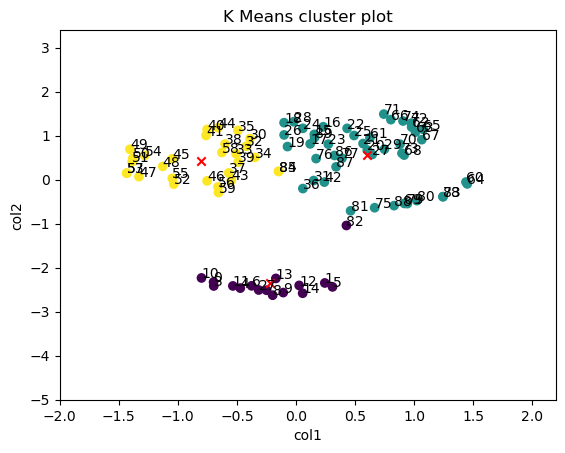

In [47]:
plt.scatter(X[:,0], X[:,1], c=cluster_labels)
plt.scatter(cent[:,0], cent[:,1], marker="x", color='r') #plot the centroids

for i in range(0,len(x)):
    txt = compound[i]
    plt.annotate(txt, (x[i], y[i]))


plt.title("K Means cluster plot")
plt.xlabel("col1")
plt.ylabel("col2")
plt.xlim(-2.0, 2.2)
plt.ylim(-5.0, 3.4);

## DBSCAN

In [48]:
from sklearn.cluster import DBSCAN

Using the default hyperparameters, DBSCAN clustered the datapoints into three clusters.

In [49]:
clustering = DBSCAN(eps = 0.5, min_samples = 5)
pred = clustering.fit_predict(X)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       2, 1])

In [50]:
score3 = round(silhouette_score(X, pred, metric='euclidean'),2)

In [51]:
score3

0.47

The lowest silhouette score was given by DBSCAN.

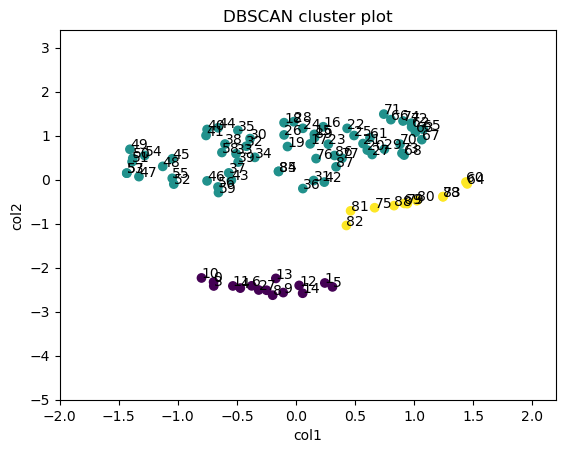

breaking at iteration 104 with stress 537.8315289287727
breaking at iteration 122 with stress 605.1413438717518
breaking at iteration 165 with stress 539.994246017935
breaking at iteration 161 with stress 841.6180863970445


In [53]:
plt.scatter(X[:,0], X[:,1], c=pred);

for i in range(0,len(df2.col1)):
    txt = df2.index[i]
    plt.annotate(txt, (df2.col1[i], df2.col2[i]))

plt.title("DBSCAN cluster plot")
plt.xlabel("col1")
plt.ylabel("col2")
plt.xlim(-2.0, 2.2)
plt.ylim(-5.0, 3.4);

Comparing the silhouette scores of the three clustering algorithms, it seems agglomerative hierarchical clustering is the best one for this data set, obtaining a silhouette score of 0.51.

In [ ]:
#df_ss = pd.DataFrame(columns=['Agglomerative','KMeans', 'DBSCAN'], index = ['Silhou'])
#df_ss.loc[0] = [score1,score2,score3]
#df_ss.rename(index={0: 'Silho'})

#df_ss = pd.DataFrame({'Agglomerative': [score1], 'KMeans':[score2], 'DBSCAN':[score3]}, index = 'Silho')
#df_ss = pd.DataFrame(data, index='Silhouette_Score')
#df_ss.index.names = ['Date']
#df_ss

In [ ]:
#df_ss